# Figure 5: Gene-level 5hmC analysis

This notebook analyses 5hmC at a gene-level to identify which genes have high levels of 5hmC. To do this, the sample CpG sites are grouped by gene and gene feature. An average ratio of 5hmCpG per CpG (5hmC level) is calculated for each gene and feature, and then a genome-wide average is calculated from that. 

We then calculate an enrichment score for each gene and feature, which is the log2 fold-ratio of the gene/feature's 5hmC level to the genome-wide (genic) average. Sorting by score, we then compare methods using Spearman's rank correlation coefficient. 

Of the genes with the highest 5hmC enrichment score (filtered), we then look at whether 5hmC is accumulated within a particular feature type. The null hypothesis is that 5hmC is randomly scattered across these genes, in which case each feature will have the same mean 5hmC level. The alternative hypothesis is that 5hmC is concentrated in a given feature, in which case a single feature will have a larger 5hmC level or at least more CpG sites that contain some 5hmC. 

In [56]:
from ProjectTools import OpenBeds
from ProjectTools.OpenBeds import filterDepth
from pybedtools import BedTool

dry = True

if dry == True:
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))
    del nano_mc_df
    tab_df = filterDepth(OpenBeds.get_bismark(tab_bed_path, "5hmC"))

else:
    tab_bed_path = './data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))
    del nano_mc_df
    tab_df = filterDepth(OpenBeds.get_bismark(tab_bed_path, "5hmC"))

names=["chromosome", "chromStart", "chromEnd", "modification_type", "readCount", "percentMeth", "method", ".", ".1", ".2", "strand"]
tab_strands_df = BedTool.intersect(BedTool.from_dataframe(tab_df), 
                                   BedTool('./data/TAB_data/CRR008807_TAB_cytosine_report.tsv.CpG_report_strands.zero.bed'), wb=True).to_dataframe(names=names).drop(columns=[".", ".1", ".2"])
tab_strands_df = tab_strands_df[["chromosome", "chromStart", "chromEnd", "strand", "modification_type", "readCount", "percentMeth", "method"]]

In [31]:
promoters_enhancers_bed = BedTool('./feature_references/fig4_features/ensembl_enhancers_promoters_modified.bed')

def intersectGenes(df):
    """
    Takes a mod df from OpenBeds and intersects it with genes and gene elements from the file below.
    """
    df = df[["chromosome", "chromStart", "chromEnd", "readCount", "percentMeth", "strand"]]
    gene_bed = BedTool('./feature_references/fig5_features/refGene_nonOverlappingExonsUTRS.bed')
    df_bed = BedTool.from_dataframe(df)
    names=["chromosome", "chromStart", "chromEnd", "readCount", "percentMeth", "strand", ".", ".1", ".2", "featureType", "geneName", ".3"]
    df_with_genes = BedTool.intersect(df_bed, gene_bed, wb=True, s=True).to_dataframe(names=names).drop(columns=[".", ".1", ".2", ".3"])

    return df_with_genes


In [54]:
import pandas as pd 
import numpy as np

def calculateGeneMean(gene_intersect_df):
    """
    Takes a gene intersect dataframe produced by intersectGenes and calculates the mean 5hmC level of each gene.
    """
    return pd.DataFrame(gene_intersect_df.groupby(["geneName"])["percentMeth"].mean()).reset_index()

def calculateLog2(mean_df):
    """
    Takes the mean dataframe produced by geneMean and adds a new column with the log2 fold change of the gene/feature's 5hmC level relative to the genome-wide average.
    """
    average_hmc_level = mean_df["percentMeth"].mean()
    mean_df["log2_diffFromMean"] = np.log2(
        np.divide(mean_df["percentMeth"], average_hmc_level)
    )
    mean_df = mean_df.loc[np.isfinite(mean_df["log2_diffFromMean"])]
    return mean_df

def methodDataProcessingFunction(mod_df):
    df_with_genes = intersectGenes(mod_df)
    gene_mean_df = calculateGeneMean(df_with_genes)
    gene_mean_log2 = calculateLog2(gene_mean_df)
    return gene_mean_log2

In [58]:
mean_gene_df = methodDataProcessingFunction(nano_hmc_df)

/u/n/doh28/.conda/envs/NanoporeEvaluationVenv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [59]:
mean_gene_df

,geneName,percentMeth,log2_diffFromMean
0,1700001G17Rik,1.605778,-2.579449
1,1700003I22Rik,14.178696,0.562932
2,1700019A02Rik,9.126667,-0.072633
3,1700019D03Rik,9.836933,0.035487
4,1700034P13Rik,4.322989,-1.150692
...,...,...,...
418,Xkr9,6.572663,-0.546243
419,Xrcc5,8.667786,-0.147058
420,Zap70,10.792568,0.169245
421,Zdbf2,6.127247,-0.647482


<Axes: ylabel='log2_diffFromMean'>

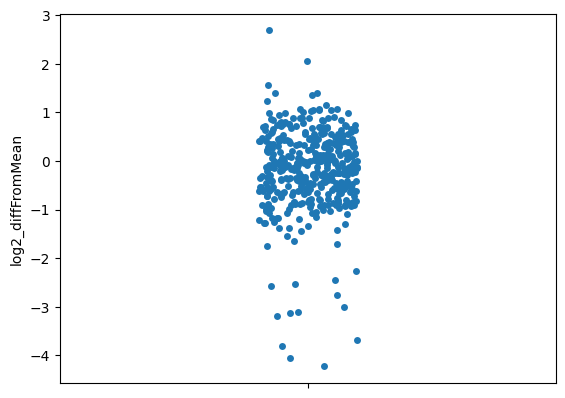

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure()

ax1 = fig.add_subplot()

sns.stripplot(mean_gene_df, y="log2_diffFromMean")
